# HepMC3 Interface: IO and visualization

impy uses the pyhepmc library for event IO and visualization. Visualization of the event is useful to understand the particle history. Not all generators produce a history. Here we generate an event with Pythia6 which has full history.

For the visualization to work, the optional package graphviz is required.

In [1]:
import impy.models as im
from impy.kinematics import CenterOfMass
from impy.constants import GeV
from impy.util import name
from particle import literals as lp, Particle

In [2]:
evt_kin = CenterOfMass(15 * GeV, "p", "p")

model = im.Pythia6(evt_kin, seed=1)

# generate one event
for event in model(1):
    pass

1                                                                              
 ******************************************************************************
 ******************************************************************************
 **                                                                          **
 **                                                                          **
 **              *......*                  Welcome to the Lund Monte Carlo!  **
 **         *:::!!:::::::::::*                                               **
 **      *::::::!!::::::::::::::*          PPP  Y   Y TTTTT H   H III   A    **
 **    *::::::::!!::::::::::::::::*        P  P  Y Y    T   H   H  I   A A   **
 **   *:::::::::!!:::::::::::::::::*       PPP    Y     T   HHHHH  I  AAAAA  **
 **   *:::::::::!!:::::::::::::::::*       P      Y     T   H   H  I  A   A  **
 **    *::::::::!!::::::::::::::::*!       P      Y     T   H   H III A   A  **
 **      *::::::!!::::::::::::::* !!    

To get a look at the event, we can `print` it, but the output is a bit confusing. impy gives access to the Fortran HepEvt record, which is a very compact and efficient format, but it is not easy to see what is going on.

In [3]:
print(event)

PYTHIA6Event(generator=('Pythia', '6.428'), kin=CenterOfMass(frame=<EventFrame.CENTER_OF_MASS: 1>, p1=<PDGID: 2212>, p2=<PDGID: 2212>, ecm=15.0, beams=(array([0.        , 0.        , 7.44103746, 7.49995954]), array([ 0.        ,  0.        , -7.44103746,  7.50004046])), _gamma_cm=7.987954748814348, _betagamma_cm=7.925113315852695), nevent=0, impact_parameter=nan, n_wounded=(0, 0), pid=array([2212, 2212,   21,   21,   21,   21,   21,   21, 2101,   21,   21,
          2,    2, 2101,   92,  223, 2214,  221, -213,  211,   92,  113,
        323, -311,  111, -211, 2212,   22,  111, 2212,  111,  211, -211,
        111, -211,  111,  211, -211,  321,  111,  130,   22,   22,   22,
         22,   22,   22,   22,   22,   22,   22,   22,   22], dtype=int32), status=array([3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), charge=array([ 1.        ,  1.        ,  0

To get a better visualization, we can convert the event into a directed graph. The HepMC3 library provides such a graph structure. We convert the impy event to HepMC3 format.

In [4]:
hev = event.to_hepmc3()

The HepMC3 event consists of particles and vertices. You can traverse the graph up and down to follow all ancestors of a final state particle.

In [5]:
# get one final state particle
for p in hev.particles:
    if p.status == 1: # final state
        break

# print particle and its parents
while True:
    print(f"{name(p.pid)} E={p.momentum.e / GeV:.3g} status={p.status}")
    if not p.production_vertex.particles_in:
        break
    p = p.production_vertex.particles_in[0]
    

pi+ E=1.32 status=1
Unknown(92) E=7.42 status=2
(ud)(0) E=3.18 status=2
p E=7.5 status=3


If you have `graphviz` installed, the HepMC3 event will be visualized directly in the notebook.

In [6]:
hev

GenEvent(momentum_unit=1, length_unit=0, event_number=0, particles=[GenParticle(FourVector(0, 0, 7.44, 7.5), mass=0.93827, pid=2212, status=3), GenParticle(FourVector(0, 0, -7.44, 7.5), mass=0.93827, pid=2212, status=3), GenParticle(FourVector(-1.52, 0.106, -1.21, 1.95), mass=-0, pid=21, status=3), GenParticle(FourVector(-0.596, -0.909, -1.33, 1.72), mass=-0, pid=21, status=3), GenParticle(FourVector(-1.52, 0.106, -1.21, 1.95), mass=0, pid=21, status=3), GenParticle(FourVector(-0.596, -0.909, -1.33, 1.72), mass=0, pid=21, status=3), GenParticle(FourVector(-1.06, -0.911, -2.08, 2.5), mass=0, pid=21, status=3), GenParticle(FourVector(-1.06, 0.109, -0.461, 1.16), mass=0, pid=21, status=3), GenParticle(FourVector(0.382, -0.319, 3.09, 3.18), mass=0.57933, pid=2101, status=2), GenParticle(FourVector(-1.06, 0.109, -0.461, 1.16), mass=0, pid=21, status=2), GenParticle(FourVector(-1.06, -0.911, -2.08, 2.5), mass=0, pid=21, status=2), GenParticle(FourVector(-0.108, 0.184, -0.423, 0.577), mass=0.33, pid=2, status=2), GenParticle(FourVector(1.14, 0.213, 3.54, 3.74), mass=0.33, pid=2, status=2), GenParticle(FourVector(0.704, 0.725, -3.66, 3.84), mass=0.57933, pid=2101, status=2), GenParticle(FourVector(-1.85, -0.938, 0.124, 7.42), mass=7.12658, pid=92, status=2), GenParticle(FourVector(0.333, -0.423, 1.76, 2), mass=0.784723, pid=223, status=2), GenParticle(FourVector(-0.189, 0.449, 0.467, 1.42), mass=1.25462, pid=2214, status=2), GenParticle(FourVector(-0.96, -0.736, 0.129, 1.33), mass=0.54745, pid=221, status=2), GenParticle(FourVector(-0.41, 0.0515, -1.1, 1.34), mass=0.647502, pid=-213, status=2), GenParticle(FourVector(-0.62, -0.279, -1.13, 1.32), mass=0.13957, pid=211, status=1), GenParticle(FourVector(1.85, 0.938, -0.124, 7.58), mass=7.28815, pid=92, status=2), GenParticle(FourVector(0.434, -0.0379, 1.36, 1.62), mass=0.769204, pid=113, status=2), GenParticle(FourVector(0.239, 0.234, 0.0971, 0.976), mass=0.911904, pid=323, status=2), GenParticle(FourVector(0.451, -0.199, 0.749, 1.03), mass=0.49767, pid=-311, status=2), GenParticle(FourVector(0.403, 0.829, -1.06, 1.41), mass=0.13498, pid=111, status=2), GenParticle(FourVector(-0.324, -0.335, 0.287, 0.565), mass=0.13957, pid=-211, status=1), GenParticle(FourVector(0.644, 0.447, -1.55, 1.98), mass=0.93827, pid=2212, status=1), GenParticle(FourVector(0.13, -0.596, 1.43, 1.56), mass=0, pid=22, status=1), GenParticle(FourVector(0.203, 0.173, 0.325, 0.442), mass=0.13498, pid=111, status=2), GenParticle(FourVector(-0.00121, 0.508, 0.51, 1.18), mass=0.93827, pid=2212, status=1), GenParticle(FourVector(-0.188, -0.0584, -0.0429, 0.242), mass=0.13498, pid=111, status=2), GenParticle(FourVector(-0.286, -0.366, -0.00861, 0.485), mass=0.13957, pid=211, status=1), GenParticle(FourVector(-0.263, -0.0568, 0.0648, 0.31), mass=0.13957, pid=-211, status=1), GenParticle(FourVector(-0.411, -0.313, 0.0725, 0.539), mass=0.13498, pid=111, status=2), GenParticle(FourVector(-0.151, 0.289, -0.742, 0.822), mass=0.13957, pid=-211, status=1), GenParticle(FourVector(-0.259, -0.238, -0.36, 0.521), mass=0.13498, pid=111, status=2), GenParticle(FourVector(-0.0117, -0.294, 0.713, 0.784), mass=0.13957, pid=211, status=1), GenParticle(FourVector(0.445, 0.256, 0.646, 0.837), mass=0.13957, pid=-211, status=1), GenParticle(FourVector(-0.0623, -0.00738, -0.121, 0.512), mass=0.4936, pid=321, status=1), GenParticle(FourVector(0.302, 0.241, 0.219, 0.464), mass=0.13498, pid=111, status=2), GenParticle(FourVector(0.451, -0.199, 0.749, 1.03), mass=0.49767, pid=130, status=1), GenParticle(FourVector(0.378, 0.81, -0.99, 1.33), mass=0, pid=22, status=1), GenParticle(FourVector(0.0242, 0.0191, -0.0744, 0.0805), mass=0, pid=22, status=1), GenParticle(FourVector(0.2, 0.161, 0.227, 0.342), mass=0, pid=22, status=1), GenParticle(FourVector(0.00325, 0.0119, 0.0986, 0.0993), mass=0, pid=22, status=1), GenParticle(FourVector(-0.184, -0.089, -0.0233, 0.206), mass=0, pid=22, status=1), GenParticle(FourVector(-0.00358, 0.0305, -0.0197, 0.0365), ma

Try hovering the mouse over the lines and nodes to get extra tooltip information about the particles and vertices.

If you have all these extra packages installed, you can also display the original impy event in this way (it is converted automatically then to generate this visualization).

In [7]:
event

PYTHIA6Event(generator=('Pythia', '6.428'), kin=CenterOfMass(frame=<EventFrame.CENTER_OF_MASS: 1>, p1=<PDGID: 2212>, p2=<PDGID: 2212>, ecm=15.0, beams=(array([0.        , 0.        , 7.44103746, 7.49995954]), array([ 0.        ,  0.        , -7.44103746,  7.50004046])), _gamma_cm=7.987954748814348, _betagamma_cm=7.925113315852695), nevent=0, impact_parameter=nan, n_wounded=(0, 0), pid=array([2212, 2212,   21,   21,   21,   21,   21,   21, 2101,   21,   21,
          2,    2, 2101,   92,  223, 2214,  221, -213,  211,   92,  113,
        323, -311,  111, -211, 2212,   22,  111, 2212,  111,  211, -211,
        111, -211,  111,  211, -211,  321,  111,  130,   22,   22,   22,
         22,   22,   22,   22,   22,   22,   22,   22,   22], dtype=int32), status=array([3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32), charge=array([ 1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.33333333,  0.        ,
        0.        ,  0.66666667,  0.66666667,  0.33333333,  0.        ,
        0.        ,  1.        ,  0.        , -1.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
       -1.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  1.        , -1.        ,  0.        , -1.        ,
        0.        ,  1.        , -1.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ]), px=array([ 0.00000000e+00,  0.00000000e+00, -1.52421782e+00, -5.95969666e-01,
       -1.52421782e+00, -5.95969666e-01, -1.05913268e+00, -1.06105480e+00,
        3.82278776e-01, -1.06105480e+00, -1.05913268e+00, -1.08275867e-01,
        1.14193904e+00,  7.04245533e-01, -1.84618457e+00,  3.32825714e-01,
       -1.88867317e-01, -9.60210970e-01, -4.09555463e-01, -6.20376539e-01,
        1.84618457e+00,  4.33654684e-01,  2.39483526e-01,  4.51059250e-01,
        4.02702360e-01, -3.24306414e-01,  6.43591170e-01,  1.29988102e-01,
        2.02837612e-01, -1.20656754e-03, -1.87660750e-01, -2.86214012e-01,
       -2.62593416e-01, -4.11403542e-01, -1.50802760e-01, -2.58752703e-01,
       -1.16865159e-02,  4.45341199e-01, -6.23348626e-02,  3.01818388e-01,
        4.51059250e-01,  3.78496793e-01,  2.42055677e-02,  1.99587262e-01,
        3.25034950e-03, -1.84077158e-01, -3.58359191e-03, -3.20484425e-01,
       -9.09191167e-02, -1.36305120e-02, -2.45122191e-01,  5.37231862e-02,
        2.48095202e-01]), py=array([ 0.        ,  0.        ,  0.10645611, -0.9087029 ,  0.10645611,
       -0.9087029 , -0.91080876,  0.10856197, -0.31942174,  0.10856197,
       -0.91080876,  0.18386456,  0.21296563,  0.72483834, -0.93780397,
       -0.42297897,  0.4491567 , -0.73624301,  0.05153475, -0.27927343,
        0.93780397, -0.03791267,  0.2340569 , -0.19932505,  0.82886879,
       -0.33524262,  0.44735862, -0.59619577,  0.1732168 ,  0.50758334,
       -0.05842664, -0.36618886, -0.05678898, -0.31326517,  0.28903905,
       -0.2375043 , -0.29429931,  0.25638664, -0.00738258,  0.24143948,
       -0.19932505,  0.80973741,  0.01913138,  0.16132646,  0.01189034,
       -0.08896856,  0.03054192, -0.17367066, -0.13959451,  0.01233596,
       -0.24984026,  0.12280427,  0.11863521]), pz=array([ 7.44107851e+00, -7.44107851e+00, -1.20901159e+00, -1.32950205e+00,
       -1.20901159e+00, -1.32950205e+00, -2.07772038e+00, -4.60793264e-01,
        3.08616955e+00, -4.60793264e-01, -2.07772038e+00, -4.23169740e-01,
        3.53586538e+00, -3.66035155e+00,  1.24486171e-01,  1.75647656e+00,
        4.66895471e-01,  1.28745860e-01, -1.10149882e+00, -1.12613289e+00,
       -1.24486171e-01,  1.35875457e+00,  9.71071230e-02,  7.48966182e-01,
       -1.06466437e+00,  2.86783961e-01

This scalable SVG image is generated with the function `pyhepmc.view.to_dot`, which produces a `DiGraph` object. It is possible to manipulate this object, for example, to change the size of the image. For details, see the `graphviz` docs.

In [8]:
from pyhepmc.view import to_dot

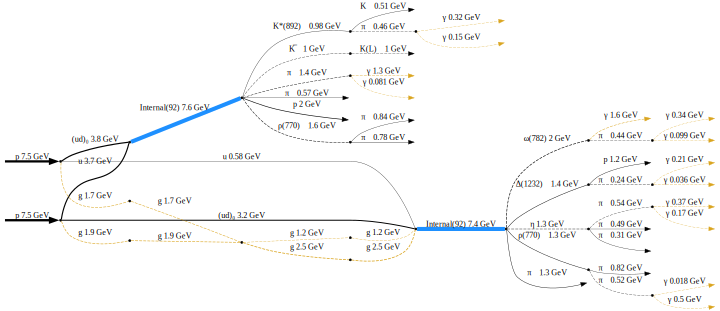

In [9]:
d = to_dot(hev)
d.graph_attr["size"] = "10,10"
d

Also important is the ability to save events and to pass them to other HEP software. The HepMC format is the common language in particle physics, which all tools understand. `pyhepmc` offers a Pythonic way to read/write events with an `open` function.

impy events can be written to disk directly without manual conversion to HepMC3 format, because `pyhepmc` respects the following protocol. If a foreign event object has a method called `to_hepmc3`, it is called to convert the event automatically before writing.

In [10]:
import pyhepmc

with pyhepmc.open("pythia6.dat", "w") as f:
    f.write(event)  # both event and hev work here

The format is human-readable ASCII.

In [11]:
with open("pythia6.dat") as f:
    print(f.read())

HepMC::Version 3.02.05
HepMC::Asciiv3-START_EVENT_LISTING
T Pythia\|6.428\|
E 0 24 53
U GEV MM
P 1 0 2212 0.0000000000000000e+00 0.0000000000000000e+00 7.4410785110157258e+00 7.5000000000000009e+00 9.3827000000000005e-01 3
P 2 0 2212 0.0000000000000000e+00 0.0000000000000000e+00 -7.4410785110157258e+00 7.5000000000000009e+00 9.3827000000000005e-01 3
P 3 1 21 -1.5242178175441157e+00 1.0645610742887258e-01 -1.2090115925955225e+00 1.9484049602580606e+00 -0.0000000000000000e+00 3
P 4 2 21 -5.9596966580058586e-01 -9.0870289635838841e-01 -1.3295020488205844e+00 1.7171186604957498e+00 -0.0000000000000000e+00 3
P 5 3 21 -1.5242178175441161e+00 1.0645610742887278e-01 -1.2090115925955232e+00 1.9484049602580620e+00 0.0000000000000000e+00 3
P 6 4 21 -5.9596966580058486e-01 -9.0870289635838830e-01 -1.3295020488205838e+00 1.7171186604957485e+00 0.0000000000000000e+00 3
V -5 0 [5,6]
P 7 -5 21 -1.0591326803489240e+00 -9.1080876239608077e-01 -2.0777203771775579e+00 2.5036486578550572e+00 0.000000000000

We can also handle incomplete records, like the one from SIBYLL-2.1.

In [12]:
evt_kin = CenterOfMass(20 * GeV, "p", "p")

model = im.Sibyll21(evt_kin, seed=1)

# generate one event
for event2 in model(1):
    pass

 |                                                  |
 |                 S I B Y L L  2.1                 |
 |                                                  |
 |         HADRONIC INTERACTION MONTE CARLO         |
 |                        BY                        |
 |                   Ralph ENGEL                    |
 |           R.S. FLETCHER, T.K. GAISSER            |
 |               P. LIPARI, T. STANEV               |
 |                                                  |
 | Publication to be cited when using this program: |
 | R. Engel et al., Proc. 26th ICRC, 1 (1999) 415   |
 |                                                  |
 | last modified:  28. Sept. 2001 by R. Engel       |


 Table: J, sqs,  PT_cut,  SIG_tot,  SIG_inel,  B_el,  rho,  <n_s>,  <n_h>
 ------------------------------------------------------------------------
    1   1.000E+01    1.45   38.33   30.88   10.83  -0.185   1.964   0.003
    1   1.259E+01    1.49   38.27   31.16   11.10  -0.127   1.949   0.006


Sibyll-2.1 does not include the beam particles in the output, so there is no common production vertex for all particles.

In [13]:
hev2 = event2.to_hepmc3()
hev2

GenEvent(momentum_unit=1, length_unit=0, event_number=0, particles=[GenParticle(FourVector(-0.0892, 0.135, 2.03, 2.38), mass=1.231, pid=2224, status=2), GenParticle(FourVector(0.0895, -0.449, 3.42, 3.45), mass=0.13497, pid=111, status=2), GenParticle(FourVector(0.15, 0.46, 2.04, 2.31), mass=0.9575, pid=331, status=2), GenParticle(FourVector(-0.162, -0.244, 1.95, 2.05), mass=0.5488, pid=221, status=2), GenParticle(FourVector(-0.0529, 0.253, -0.0519, 0.299), mass=0.13957, pid=-211, status=1), GenParticle(FourVector(-0.0249, 0.366, -1.89, 1.93), mass=0.13497, pid=111, status=2), GenParticle(FourVector(0.0898, -0.521, -7.5, 7.58), mass=0.93827, pid=2212, status=1), GenParticle(FourVector(-0.11, 0.0929, 1.17, 1.51), mass=0.93827, pid=2212, status=1), GenParticle(FourVector(0.0211, 0.0421, 0.864, 0.876), mass=0.13957, pid=211, status=1), GenParticle(FourVector(-0.0159, -0.26, 1.94, 1.96), mass=0, pid=22, status=1), GenParticle(FourVector(0.105, -0.189, 1.48, 1.49), mass=0, pid=22, status=1), GenParticle(FourVector(0.013, 0.0959, 0.226, 0.283), mass=0.13957, pid=211, status=1), GenParticle(FourVector(0.0956, 0.0602, 0.122, 0.218), mass=0.13957, pid=-211, status=1), GenParticle(FourVector(0.0413, 0.304, 1.69, 1.81), mass=0.5488, pid=221, status=2), GenParticle(FourVector(-0.135, 0.0444, 1.53, 1.54), mass=0, pid=22, status=1), GenParticle(FourVector(-0.027, -0.289, 0.421, 0.512), mass=0, pid=22, status=1), GenParticle(FourVector(-0.045, 0.262, -1.59, 1.61), mass=0, pid=22, status=1), GenParticle(FourVector(0.0201, 0.104, -0.307, 0.325), mass=0, pid=22, status=1), GenParticle(FourVector(0.0162, 0.112, 0.307, 0.357), mass=0.13957, pid=211, status=1), GenParticle(FourVector(-0.0502, 0.0778, 0.268, 0.317), mass=0.13957, pid=-211, status=1), GenParticle(FourVector(0.0753, 0.114, 1.11, 1.13), mass=0.13497, pid=111, status=2), GenParticle(FourVector(0.0689, -0.0035, 0.546, 0.551), mass=0, pid=22, status=1), GenParticle(FourVector(0.00639, 0.118, 0.569, 0.582), mass=0, pid=22, status=1)], vertices=[GenVertex(FourVector(0, 0, 0, 0)), GenVertex(FourVector(0, 0, 0, 0)), GenVertex(FourVector(0, 0, 0, 0)), GenVertex(FourVector(0, 0, 0, 0)), GenVertex(FourVector(0, 0, 0, 0)), GenVertex(FourVector(0, 0, 0, 0)), GenVertex(FourVector(0, 0, 0, 0))], run_info=GenRunInfo(tools=[ToolInfo(name='SIBYLL', version='2.1', description='')], weight_names=[], attributes={}))

The serialized output is more compact. For SIBYLL-2.1, the vertex positions are all zero, and the HepMC3 format then optimizes the vertex entries away.

In [14]:
with pyhepmc.open("sibyll21.dat", "w") as f:
    f.write(event2)
    
with open("sibyll21.dat") as f:
    print(f.read())

HepMC::Version 3.02.05
HepMC::Asciiv3-START_EVENT_LISTING
T SIBYLL\|2.1\|
E 0 7 23
U GEV MM
P 1 0 2224 -8.9205041527748108e-02 1.3491769134998322e-01 2.0344371795654297e+00 2.3833706378936768e+00 1.2309999465942383e+00 2
P 2 0 111 8.9463070034980774e-02 -4.4863110780715942e-01 3.4179518222808838e+00 3.4519975185394287e+00 1.3496999442577362e-01 2
P 3 0 331 1.4990800619125366e-01 4.6003237366676331e-01 2.0358951091766357e+00 2.3069748878479004e+00 9.5749998092651367e-01 2
P 4 0 221 -1.6207817196846008e-01 -2.4423867464065552e-01 1.9545348882675171e+00 2.0511729717254639e+00 5.4879999160766602e-01 2
P 5 0 -211 -5.2947159856557846e-02 2.5346320867538452e-01 -5.1904711872339249e-02 2.9869863390922546e-01 1.3956999778747559e-01 1
P 6 0 111 -2.4904966354370117e-02 3.6575528979301453e-01 -1.8918764591217041e+00 1.9317893981933594e+00 1.3496999442577362e-01 2
P 7 0 2212 8.9764386415481567e-02 -5.2129906415939331e-01 -7.4990553855895996e+00 7.5760145187377930e+00 9.3826997280120850e-01 1
P 8 1 